## Import Necessary Libraries

In [273]:
import pandas as pd
import tensorflow as tf
import os
import numpy as np
import itertools
import random
import PIL
from PIL import Image
import io

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten, \
GlobalAveragePooling2D, BatchNormalization, Resizing, Rescaling, RandomFlip, RandomRotation

from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from keras import models, layers 
from keras_preprocessing.image import load_img, array_to_img, img_to_array, ImageDataGenerator
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import  Adam

from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from sklearn.metrics import plot_confusion_matrix, confusion_matrix

## Load the Files of Images

In [274]:
datagen = ImageDataGenerator()

In [275]:
train_path =  './data/fruits-360_dataset/fruits-360/Training'
test_path = './data/fruits-360_dataset/fruits-360/Test'
val_path = './data/fruits-360_dataset/fruits-360/Validation'

In [276]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2, 
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   rotation_range=10, 
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   channel_shift_range=10.)

test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [277]:
image_size = (100, 100)
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = image_size,
    batch_size = 7841,
    color_mode = 'rgb',
    class_mode = 'categorical')

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size = image_size,
    batch_size = 3017,
    color_mode = 'rgb',
    class_mode = 'categorical')

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size = image_size,
    batch_size = 1207,
    color_mode = 'rgb',
    class_mode = 'categorical')

Found 7841 images belonging to 6 classes.
Found 3017 images belonging to 6 classes.
Found 1207 images belonging to 6 classes.


In [278]:
train_class_names = list(train_generator.class_indices.keys())
train_class_names

['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden',
 'Apple Granny Smith',
 'Apple Pink Lady',
 'Apple Red Delicious']

In [279]:
test_class_names = list(test_generator.class_indices.keys())
test_class_names

['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden',
 'Apple Granny Smith',
 'Apple Pink Lady',
 'Apple Red Delicious']

In [280]:
val_class_names = list(val_generator.class_indices.keys())
val_class_names

['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden',
 'Apple Granny Smith',
 'Apple Pink Lady',
 'Apple Red Delicious']

## Begin Modeling

#### Baseline Model

In [281]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [282]:
# enc_train_labels = to_categorical(train_labels) #/255
# enc_train_images = to_categorical(train_images)

# enc_test_labels = to_categorical(test_labels)/255
# enc_test_images = to_categorical(test_images)

# enc_val_labels = to_categorical(val_labels)/255
# enc_val_images = to_categorical(val_images)

In [283]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

In [284]:
# print(train_img.shape)
# print(test_img.shape)
# print(val_img.shape)

In [285]:
train_labels

array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [286]:
train_images.shape

(7841, 100, 100, 3)

In [287]:
train_labels.shape

(7841, 6)

In [288]:
# train_y = np.reshape(train_labels[:,0], (32, ))
# test_y = np.reshape(test_labels[:,0], (32, ))
# val_y = np.reshape(val_labels[:,0], (32, ))

In [289]:
#Instantiate a Regularizer
reg = l2(3e-3)

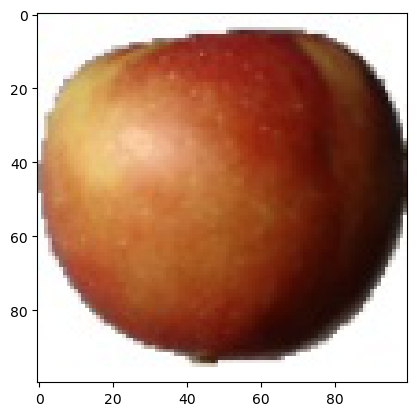

In [290]:
chosen_image = random.choice(os.listdir('./data/fruits-360_dataset/fruits-360/Training/Apple Braeburn/'))
image_path = './data/fruits-360_dataset/fruits-360/Training/Apple Braeburn/' + chosen_image
image = np.expand_dims(plt.imread(image_path),0)
plt.imshow(image[0])

In [291]:
def augment_images(apple_name):
    names = [os.path.join(f'./data/fruits-360_dataset/fruits-360/Training/{apple_name}/'
                      , name) for name in os.listdir(f'./data/fruits-360_dataset/fruits-360/Training/{apple_name}/')]
    for f in names:
        if f.endswith('.jpg'):
            img = Image.open(f)
            x = img_to_array(img) 
            # Reshape the input image 
            x = x.reshape((1, ) + x.shape)  
            i = 0

            # generate 2 new augmented images 
            for batch in train_datagen.flow(x, batch_size = 1, 
                              save_to_dir = f'./data/fruits-360_dataset/fruits-360/Training/{apple_name}',  
                              save_prefix = 'aug-image-', save_format ='jpg'):
                i += 1
                if i > 2: 
                    break

In [292]:
# DO NOT RUN
# augment_images('Apple Braeburn')
# augment_images('Apple Crimson Snow')
# augment_images('Apple Golden')
# augment_images('Apple Granny Smith')
# augment_images('Apple Pink Lady')
# augment_images('Apple Red Delicious')

In [293]:
# aug_iter = train_datagen.flow(augment_images, 
#                               save_to_dir='./data/fruits-360_dataset/fruits-360_2/Txraining/Apple Braeburn', 
#                               save_prefix='aug-image-', 
#                               save_format='jpeg')

In [294]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [295]:
baseline_model = models.Sequential()
baseline_model.add(layers.Conv2D(18, (3,3), activation='relu', input_shape=(100, 100, 3))) # 2 hidden layers
baseline_model.add(layers.MaxPooling2D(2,2))
baseline_model.add(layers.Dropout(0.3))
baseline_model.add(layers.Conv2D(36, (3,3), activation='relu')) # 2 hidden layers
baseline_model.add(layers.Dropout(0.25))
baseline_model.add(layers.MaxPooling2D(2,2))
baseline_model.add(layers.Dropout(0.2))
#baseline_model.add(BatchNormalization())
baseline_model.add(layers.Flatten())
baseline_model.add(layers.Dense(24, activation='relu', kernel_regularizer = reg))
# baseline_model.add(layers.Dense(48, activation='relu', kernel_regularizer = reg))
# baseline_model.add(layers.Dense(24, activation='relu', kernel_regularizer = reg))
baseline_model.add(layers.Dense(6, activation='softmax', kernel_regularizer = reg))
#Check example of dropout, towrards start, filyters
# CNNS Intro
# 

In [296]:
train_images.shape

(7841, 100, 100, 3)

In [297]:
train_labels.shape

(7841, 6)

In [298]:
opt = Adam(learning_rate=0.00001)
es = EarlyStopping(monitor='val_loss', mode='min', min_delta = 1e-8, patience = 50)


np.random.seed(42)
baseline_model.compile(optimizer=opt,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

baseline_histoire = baseline_model.fit(train_images,
                                       train_labels,
                                       #callbacks = [es],
                                       epochs = 100,
                                       batch_size = 80,
                                       validation_data = (val_images, val_labels))

Epoch 1/100


2022-12-07 17:12:32.522951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - ETA: 0s - loss: 1.9119 - accuracy: 0.2630

2022-12-07 17:12:36.856369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 5s 45ms/step - loss: 1.9119 - accuracy: 0.2630 - val_loss: 1.8622 - val_accuracy: 0.3786
Epoch 2/100
99/99 [==============================] - 4s 38ms/step - loss: 1.7484 - accuracy: 0.3764 - val_loss: 1.7690 - val_accuracy: 0.4938
Epoch 3/100
99/99 [==============================] - 4s 37ms/step - loss: 1.6151 - accuracy: 0.4326 - val_loss: 1.6878 - val_accuracy: 0.5394
Epoch 4/100
99/99 [==============================] - 4s 37ms/step - loss: 1.4986 - accuracy: 0.4899 - val_loss: 1.6231 - val_accuracy: 0.5170
Epoch 5/100
99/99 [==============================] - 4s 39ms/step - loss: 1.4002 - accuracy: 0.5319 - val_loss: 1.5455 - val_accuracy: 0.5352
Epoch 6/100
99/99 [==============================] - 4s 41ms/step - loss: 1.3055 - accuracy: 0.5708 - val_loss: 1.5000 - val_accuracy: 0.5891
Epoch 7/100
99/99 [==============================] - 4s 45ms/step - loss: 1.2242 - accuracy: 0.6074 - val_loss: 1.4541 - val_accuracy: 0.5816
Epoch 8/100
99/99 

99/99 [==============================] - 4s 37ms/step - loss: 0.3494 - accuracy: 0.9385 - val_loss: 1.0579 - val_accuracy: 0.7490
Epoch 59/100
99/99 [==============================] - 4s 37ms/step - loss: 0.3436 - accuracy: 0.9434 - val_loss: 1.0565 - val_accuracy: 0.7680
Epoch 60/100
99/99 [==============================] - 4s 37ms/step - loss: 0.3451 - accuracy: 0.9401 - val_loss: 1.0656 - val_accuracy: 0.7630
Epoch 61/100
99/99 [==============================] - 4s 37ms/step - loss: 0.3385 - accuracy: 0.9425 - val_loss: 1.0147 - val_accuracy: 0.7763
Epoch 62/100
99/99 [==============================] - 4s 37ms/step - loss: 0.3337 - accuracy: 0.9463 - val_loss: 1.0844 - val_accuracy: 0.7506
Epoch 63/100
99/99 [==============================] - 4s 37ms/step - loss: 0.3318 - accuracy: 0.9464 - val_loss: 1.0626 - val_accuracy: 0.7564
Epoch 64/100
99/99 [==============================] - 4s 37ms/step - loss: 0.3392 - accuracy: 0.9445 - val_loss: 1.0190 - val_accuracy: 0.7771
Epoch 65/100

In [299]:
baseline_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 98, 98, 18)        504       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 49, 49, 18)       0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 49, 49, 18)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 47, 47, 36)        5868      
                                                                 
 dropout_25 (Dropout)        (None, 47, 47, 36)        0         
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 23, 23, 36)       0         
 g2D)                                                

In [300]:
baseline_results_train = baseline_model.evaluate(train_images, train_labels)
baseline_results_test = baseline_model.evaluate(test_images, test_labels)

95/95 [==============================] - 1s 13ms/step - loss: 1.5083 - accuracy: 0.7222


In [301]:
print(f'Baseline Train Results: {baseline_results_train}')
print(f'Baseline Test Results: {baseline_results_test}')

Baseline Train Results: [0.3805387616157532, 0.9181227684020996]
Baseline Test Results: [1.5083258152008057, 0.7222406268119812]


#### Baseline Model Visualizations

#### Graphing Accuracy and Loss Metrics

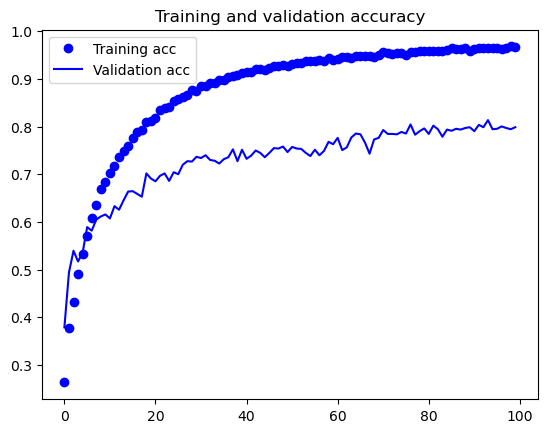

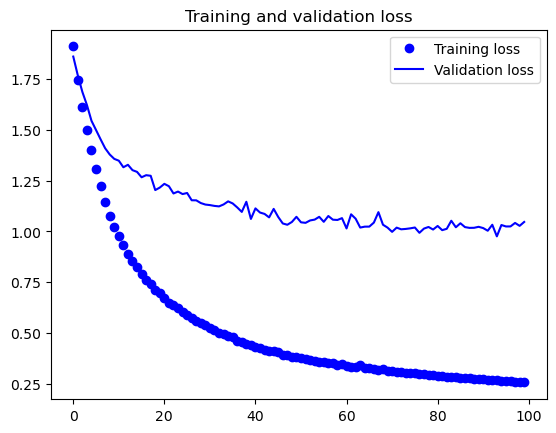

In [302]:
# Plot history
acc = baseline_histoire.history['accuracy']
val_acc = baseline_histoire.history['val_accuracy']
loss = baseline_histoire.history['loss']
val_loss = baseline_histoire.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show();



#### Confusion Matrix

/Users/skyejeanat/miniforge3/envs/tensorflow_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
2022-12-07 17:18:49.542202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


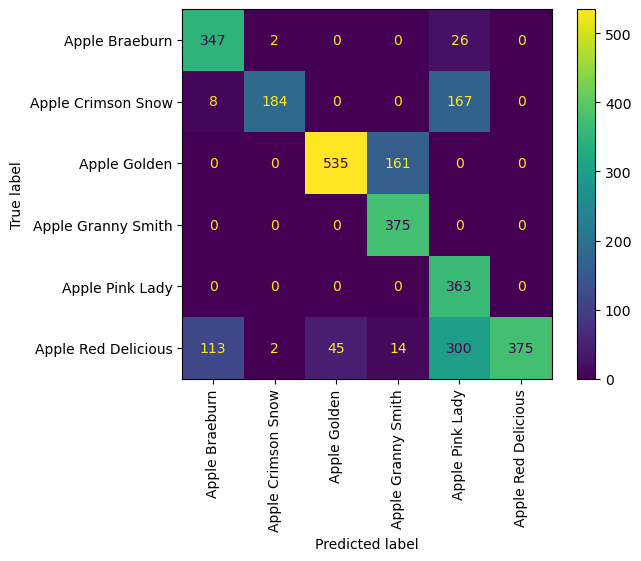

In [303]:
class_names = train_class_names
class estimator:
    _estimator_type = ''
    classes_= []
    def __init__(self, model, classes):
        self.model = model
        self._estimator_type = 'classifier'
        self.classes_ = classes
    def predict(self, X):
        y_prob = self.model.predict(X)
        y_pred = y_prob.argmax(axis=1)

        return y_pred

classifier = estimator(baseline_model, class_names)
plot_confusion_matrix(estimator = classifier, 
                      X = test_images, 
                      y_true = np.argmax(test_labels, axis = -1),
                      display_labels = class_names,
                     xticks_rotation = 'vertical');

In [319]:
test_labels

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

#### Second Model

In [320]:
sz = 200

# Initializing the CNN
model1 = Sequential()

# First convolution layer and pooling
model1.add(Convolution2D(32, (3, 3), input_shape=(sz, sz, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size = (2, 2)))

# Second convolution layer and pooling
model1.add(Convolution2D(32, (3, 3), activation='relu'))
# input_shape is going to be the pooled feature maps from the previous convolution layer
model1.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening the layers
model1.add(Flatten(input_shape = (28,28)))

# Adding a fully connected layer
model1.add(Dense(units=96, activation='relu'))
model1.add(Dropout(0.40))
model1.add(Dense(units=32, activation='relu'))
model1.add(Dense(units=24, activation='softmax')) # softmax for more than 2

In [321]:
model1.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 99, 99, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 97, 97, 32)        9248      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 73728)             0         
                                                                 
 dense_34 (Dense)            (None, 96)              

In [322]:
model1.compile(optimizer='adam',
               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
               metrics=['accuracy'])

In [323]:
# history = model1.fit(
#     train_generator,
#     validation_data = test_generator,
#     epochs = 5
# )